# Transformers in Action

We will now focus on the key components that make transformers so impactful and go through some hands-on exercises

## Attention is All you Need ⚠️
We leveraged a basic RNN based network to generate text in the previous notebook. To enhance performance of sequence to sequence tasks a typical Encoder-Decoder architecture is the go-to choice.

<img src="assets/encoder_decoder_nb_2.png">


Let us consider the case of **Machine Translation**, i.e. translation of English to Spanish (or any other language).

In a typical __Encoder-Decoder__ architecture, the Encoder takes in the input text in English as input and prepares a condensed vector representation of the whole input. Typically termed as bottleneck features. The Decoder then uses these features to generate the translated text in Spanish.

While this architecture and its variants worked wonders, they had issues. Issues such as inability handle longer input sequences, cases where there is not a one to one mapping between input vs output language and so on.

To handle these issues, __Vasvani et. al.__ in their now famouly titled paper __Attention Is All You Need__ build up on the concepts of attention. The main highlight of this work was the Transformer architecture. Transformers were shown to present state of the art results on multiple benchmarks without using any recurrence or convolutional components.


### Attention & Self-Attention
The concept of __Attention__ is a simple yet important one. In layman terms, it helps the model focus on not just the current input but also determine specific pieces of information from the past. This helps in models which are able to handle long range dependencies along with scenarios where there is not a one to one mapping between inputs and outputs. The following is a sample illustration from the paper demonstrating the focus/attention of the model on the words when making is the input.

<img src="assets/attention_nb_2.png">

> Source: [Vasvani et. al.](https://arxiv.org/pdf/1706.03762.pdf)


__Self-attention__ is a mechanism that allows the transformer model to weigh the importance of different positions (or "tokens") __within__ a sequence when encoding or decoding.

__Multi-head attention__ extends the self-attention mechanism by performing multiple parallel self-attention operations, each focusing on different learned linear projections of the input. Multiple attention heads allow the model to capture different types of relationships and learn more fine-grained representations (eg: grammar, context, dependency, etc.)

<img src="assets/multihead_attention_nb_2.png">

> Source: [Vasvani et. al.](https://arxiv.org/pdf/1706.03762.pdf)


### Positional Encoding
Positional encoding is a technique used to incorporate the position of each token in the input sequence. It provides the model with information about the token's position without relying solely on the order of tokens.
This additional aspect was required because transformers do not have the natural sequential setup of RNNs. In order to provide positional context, any encoding system should ideally have the following properties:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

<img src="assets/positional_emb_nb_2.png">



### References
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time, math
from torch.nn import functional as F
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
DATA_DIR = "data/"

## A quick snippet of the book

In [3]:
filename = DATA_DIR + "sherlock_homes.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
print(raw_text[1500:1600])

she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she


## Prepare Text, vocab and lookups

In [4]:
text = raw_text [1450:]
text = text.lower()
print("total characters =", len(text))
vocab = list(sorted(set(text)))
vocab_size = len(vocab)
print("vocab size =", vocab_size)
stoi = {c: i for i,c in enumerate(vocab)}
itos = {i: c for i,c in enumerate(vocab)}

total characters = 580083
vocab size = 68


In [5]:
device = "cpu"
if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
print("device =", device)

device = mps


## Utilities to Train and Predict

In [6]:
context_size = 100
batch_size = 16

In [7]:
def get_batch(batch_index=None):
    data = text
    if batch_index is not None:
        # creating batch specified by batch_index
        max_batches = (len(data) - context_size - 1) // batch_size
        batch_index = batch_index % max_batches
        ix = torch.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    else:
        # creating random batch
        ix = torch.randint(len(data) - context_size, (batch_size,))
    x = torch.ones(batch_size, context_size, dtype=torch.long)
    y = torch.ones(batch_size, context_size, dtype=torch.long)
    for i, index in enumerate(ix):
        x[i] = torch.tensor([stoi[c] for c in data[index:index+context_size]])
        y[i] = torch.tensor([stoi[c] for c in data[index+1:index+context_size+1]])
    x, y = x.to(device), y.to(device)
    return x, y

In [8]:
@torch.no_grad()
def estimate_loss(model):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(batch_index=k)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    out = losses.mean()
    model.train()
    return out

In [9]:
@torch.no_grad()
def generate(
    model,
    idx,
    max_new_tokens,
    temperature=1.0,
    top_k=None,
    prompt=None,
):

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = (
            idx
            if idx.size(1) <= context_size
            else idx[:, -context_size :]
        )
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float("Inf")
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [10]:
eval_only = False
max_iters =15000
eval_interval = 20  # evaluation of model every eval_interval iterations
do_log = True  # enable logging
log_interval = 3  # log metrics about the model training every log_interval iterations
eval_iters = 20  # number of batches to evaluate on during evaluation

In [11]:
def train(model):
    iter_num = 0
    best_loss = 1e9
    losses=[[],[]]
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    X, Y = get_batch()  # fetch the very first batch
    t0 = time.time()
    while True:
        # evaluate the loss
        if iter_num % eval_interval == 0:
            loss = estimate_loss(model)
            losses[0].append(iter_num)
            losses[1].append(loss.item())
            if not eval_only and loss < best_loss:
                best_loss = loss
                print(f"eval {iter_num}: loss {loss:.4f}, improved")
            else:
                print(f"eval {iter_num}: loss {loss:.4f}")
        if eval_only:
            break

        # forward pass
        logits, loss = model(X, Y)
        X, Y = get_batch()
        # back prop
        loss.backward()
        optimizer.step()
        # flush gradients and free-up memory
        optimizer.zero_grad(set_to_none=True)

        # timing and logging
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        if do_log and iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss:.4f}, time {dt*1000:.2f}ms")
        iter_num += 1

        # termination conditions
        if iter_num > max_iters:
            break
    return model, losses, best_loss

In [12]:
class CausalSelfAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config["n_embd"] % config["n_head"] == 0
        self.c_attn = torch.nn.Linear(config["n_embd"], 3 * config["n_embd"])
        self.c_proj = torch.nn.Linear(config["n_embd"], config["n_embd"])
        self.n_head = config["n_head"]
        self.n_embd = config["n_embd"]

        self.register_buffer("bias",torch.tril(torch.ones(config["block_size"],
                                                          config["block_size"])).view(
                1, 1, config["block_size"], config["block_size"]))

    def forward(self, x):
        B,T,C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        attn = self.c_attn(x)
        q, k, v = attn.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (y.transpose(1, 2).contiguous().view(B, T, C))
        y = self.c_proj(y)
        return y

class MLP(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = torch.nn.Linear(config["n_embd"], config["n_embd"])

    def forward(self, x):
        x = self.c_fc(x)
        return x

class Block(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = torch.nn.LayerNorm(config["n_embd"])
        self.attn = CausalSelfAttention(config)
        self.ln_2 = torch.nn.LayerNorm(config["n_embd"])
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = torch.nn.ModuleDict(dict(
            wte=torch.nn.Embedding(config["vocab_size"],config["n_embd"]),
            wpe=torch.nn.Embedding(config["block_size"], config["n_embd"]),
            h=torch.nn.ModuleList([Block(config) for _ in range(config["n_layer"])]),
            ln_f=torch.nn.LayerNorm(config["n_embd"])))
        self.lm_head = torch.nn.Linear(config["n_embd"], config["vocab_size"], bias=False)
        self.transformer.wte.weight = self.lm_head.weight

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config["block_size"]
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)

        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)),targets.view(-1))
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

In [13]:
config = dict(n_layer=2,n_head=4,n_embd=72,block_size=context_size,vocab_size=vocab_size)
gpt_model = GPT(config)
gpt_model = gpt_model.to(device)
print(gpt_model)
print("parameters =", sum(p.numel() for p in gpt_model.parameters() if p.requires_grad))

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(68, 72)
    (wpe): Embedding(100, 72)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=72, out_features=216, bias=True)
          (c_proj): Linear(in_features=72, out_features=72, bias=True)
        )
        (ln_2): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=72, out_features=72, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=72, out_features=68, bias=False)
)
parameters = 65376


In [14]:
gpt_model, gpt_losses, gpt_best_loss = train(gpt_model)

eval 0: loss 4.4181, improved
iter 0: loss 4.4061, time 430.95ms
iter 3: loss 3.9851, time 14.78ms
iter 6: loss 3.3641, time 15.19ms
iter 9: loss 3.1273, time 14.95ms
iter 12: loss 3.0745, time 14.77ms
iter 15: loss 3.0351, time 14.60ms
iter 18: loss 3.1188, time 14.67ms
eval 20: loss 2.9566, improved
iter 21: loss 3.1076, time 14.65ms
iter 24: loss 3.0377, time 14.67ms
iter 27: loss 3.0359, time 14.60ms
iter 30: loss 3.0500, time 14.64ms
iter 33: loss 3.0416, time 14.79ms
iter 36: loss 3.0349, time 14.72ms
iter 39: loss 3.0041, time 14.60ms
eval 40: loss 2.9506, improved
iter 42: loss 2.9986, time 14.69ms
iter 45: loss 3.0256, time 14.73ms
iter 48: loss 2.9937, time 16.18ms
iter 51: loss 3.0274, time 14.74ms
iter 54: loss 3.0524, time 14.93ms
iter 57: loss 3.0092, time 15.22ms
eval 60: loss 2.9501, improved
iter 60: loss 3.0337, time 124.10ms
iter 63: loss 3.0389, time 14.67ms
iter 66: loss 2.9964, time 14.80ms
iter 69: loss 3.0444, time 14.64ms
iter 72: loss 3.0433, time 14.75ms
iter

iter 618: loss 2.5584, time 15.61ms
eval 620: loss 2.5182
iter 621: loss 2.6749, time 14.68ms
iter 624: loss 2.5373, time 14.65ms
iter 627: loss 2.5273, time 14.92ms
iter 630: loss 2.5462, time 14.67ms
iter 633: loss 2.5358, time 14.85ms
iter 636: loss 2.5309, time 14.56ms
iter 639: loss 2.5077, time 14.65ms
eval 640: loss 2.5171
iter 642: loss 2.5114, time 14.70ms
iter 645: loss 2.5803, time 14.69ms
iter 648: loss 2.4876, time 14.72ms
iter 651: loss 2.5047, time 14.75ms
iter 654: loss 2.5920, time 15.23ms
iter 657: loss 2.5456, time 14.68ms
eval 660: loss 2.5109, improved
iter 660: loss 2.5003, time 124.25ms
iter 663: loss 2.5228, time 14.64ms
iter 666: loss 2.5131, time 14.64ms
iter 669: loss 2.6011, time 14.59ms
iter 672: loss 2.5981, time 14.55ms
iter 675: loss 2.5140, time 14.63ms
iter 678: loss 2.5760, time 15.74ms
eval 680: loss 2.5230
iter 681: loss 2.4658, time 14.75ms
iter 684: loss 2.4818, time 14.67ms
iter 687: loss 2.5660, time 14.71ms
iter 690: loss 2.5621, time 14.43ms
i

iter 1239: loss 2.4666, time 15.54ms
eval 1240: loss 2.4708
iter 1242: loss 2.5297, time 14.68ms
iter 1245: loss 2.4649, time 14.59ms
iter 1248: loss 2.4349, time 14.92ms
iter 1251: loss 2.4438, time 14.67ms
iter 1254: loss 2.5581, time 14.77ms
iter 1257: loss 2.4137, time 14.48ms
eval 1260: loss 2.4927
iter 1260: loss 2.4354, time 125.25ms
iter 1263: loss 2.4900, time 15.19ms
iter 1266: loss 2.4878, time 14.72ms
iter 1269: loss 2.5314, time 14.58ms
iter 1272: loss 2.4382, time 14.59ms
iter 1275: loss 2.4894, time 14.90ms
iter 1278: loss 2.4633, time 15.19ms
eval 1280: loss 2.4950
iter 1281: loss 2.4578, time 15.01ms
iter 1284: loss 2.4734, time 14.65ms
iter 1287: loss 2.5392, time 14.68ms
iter 1290: loss 2.5398, time 14.69ms
iter 1293: loss 2.5143, time 14.68ms
iter 1296: loss 2.5469, time 15.41ms
iter 1299: loss 2.4744, time 14.75ms
eval 1300: loss 2.4788
iter 1302: loss 2.4277, time 14.67ms
iter 1305: loss 2.4659, time 15.39ms
iter 1308: loss 2.4634, time 14.83ms
iter 1311: loss 2.4

eval 1840: loss 2.4257
iter 1842: loss 2.4421, time 15.42ms
iter 1845: loss 2.4300, time 15.50ms
iter 1848: loss 2.3788, time 15.17ms
iter 1851: loss 2.4286, time 14.95ms
iter 1854: loss 2.3755, time 15.31ms
iter 1857: loss 2.3918, time 14.98ms
eval 1860: loss 2.4214
iter 1860: loss 2.3540, time 127.53ms
iter 1863: loss 2.3335, time 17.86ms
iter 1866: loss 2.3827, time 14.81ms
iter 1869: loss 2.3759, time 14.60ms
iter 1872: loss 2.4109, time 14.76ms
iter 1875: loss 2.3588, time 14.64ms
iter 1878: loss 2.3627, time 14.54ms
eval 1880: loss 2.4012, improved
iter 1881: loss 2.4131, time 14.52ms
iter 1884: loss 2.3341, time 16.28ms
iter 1887: loss 2.3876, time 16.51ms
iter 1890: loss 2.3628, time 15.17ms
iter 1893: loss 2.3699, time 14.68ms
iter 1896: loss 2.3299, time 14.74ms
iter 1899: loss 2.3889, time 14.77ms
eval 1900: loss 2.4089
iter 1902: loss 2.3783, time 14.72ms
iter 1905: loss 2.3978, time 14.59ms
iter 1908: loss 2.3347, time 14.67ms
iter 1911: loss 2.3992, time 14.65ms
iter 1914

iter 2448: loss 2.2792, time 14.71ms
iter 2451: loss 2.3136, time 14.59ms
iter 2454: loss 2.2294, time 14.68ms
iter 2457: loss 2.3108, time 14.79ms
eval 2460: loss 2.3329
iter 2460: loss 2.2678, time 125.27ms
iter 2463: loss 2.2794, time 14.66ms
iter 2466: loss 2.2116, time 14.65ms
iter 2469: loss 2.2855, time 14.85ms
iter 2472: loss 2.2925, time 15.07ms
iter 2475: loss 2.2475, time 14.76ms
iter 2478: loss 2.1932, time 14.64ms
eval 2480: loss 2.3100, improved
iter 2481: loss 2.2867, time 14.65ms
iter 2484: loss 2.2955, time 14.61ms
iter 2487: loss 2.2323, time 14.73ms
iter 2490: loss 2.2154, time 14.67ms
iter 2493: loss 2.2740, time 14.69ms
iter 2496: loss 2.1920, time 14.71ms
iter 2499: loss 2.2662, time 14.65ms
eval 2500: loss 2.3152
iter 2502: loss 2.2394, time 14.73ms
iter 2505: loss 2.2923, time 14.56ms
iter 2508: loss 2.1661, time 14.71ms
iter 2511: loss 2.2156, time 14.61ms
iter 2514: loss 2.2470, time 14.69ms
iter 2517: loss 2.2284, time 14.78ms
eval 2520: loss 2.3293
iter 2520

iter 3048: loss 2.1959, time 14.87ms
iter 3051: loss 2.0903, time 14.61ms
iter 3054: loss 2.1122, time 15.52ms
iter 3057: loss 2.0876, time 15.90ms
eval 3060: loss 2.2274
iter 3060: loss 2.0902, time 129.21ms
iter 3063: loss 2.0547, time 14.71ms
iter 3066: loss 2.1709, time 14.60ms
iter 3069: loss 2.1733, time 14.60ms
iter 3072: loss 2.1373, time 14.73ms
iter 3075: loss 2.1529, time 14.97ms
iter 3078: loss 2.1600, time 14.60ms
eval 3080: loss 2.2386
iter 3081: loss 2.2030, time 14.88ms
iter 3084: loss 2.1625, time 14.80ms
iter 3087: loss 2.2184, time 14.56ms
iter 3090: loss 2.1235, time 14.72ms
iter 3093: loss 2.1587, time 14.76ms
iter 3096: loss 2.1557, time 14.67ms
iter 3099: loss 2.0938, time 15.32ms
eval 3100: loss 2.2313
iter 3102: loss 2.1603, time 14.96ms
iter 3105: loss 2.0853, time 14.90ms
iter 3108: loss 2.0699, time 14.75ms
iter 3111: loss 2.0962, time 14.79ms
iter 3114: loss 2.1124, time 14.93ms
iter 3117: loss 2.1175, time 14.75ms
eval 3120: loss 2.2507
iter 3120: loss 2.1

iter 3654: loss 2.0330, time 16.03ms
iter 3657: loss 2.0732, time 15.37ms
eval 3660: loss 2.1959, improved
iter 3660: loss 2.1039, time 125.62ms
iter 3663: loss 2.0497, time 14.76ms
iter 3666: loss 2.1266, time 14.52ms
iter 3669: loss 2.0343, time 14.44ms
iter 3672: loss 2.0545, time 14.64ms
iter 3675: loss 2.1050, time 15.61ms
iter 3678: loss 2.0194, time 14.82ms
eval 3680: loss 2.1912, improved
iter 3681: loss 2.1122, time 14.98ms
iter 3684: loss 2.0786, time 14.90ms
iter 3687: loss 1.9731, time 14.49ms
iter 3690: loss 2.0293, time 14.45ms
iter 3693: loss 2.0550, time 14.51ms
iter 3696: loss 2.0735, time 15.82ms
iter 3699: loss 2.0517, time 14.52ms
eval 3700: loss 2.1857, improved
iter 3702: loss 2.0651, time 14.81ms
iter 3705: loss 2.0671, time 14.78ms
iter 3708: loss 2.0416, time 14.56ms
iter 3711: loss 2.1490, time 14.73ms
iter 3714: loss 2.0814, time 14.61ms
iter 3717: loss 2.0314, time 14.71ms
eval 3720: loss 2.1759, improved
iter 3720: loss 2.0135, time 124.59ms
iter 3723: loss

eval 4260: loss 2.1581
iter 4260: loss 2.0832, time 124.92ms
iter 4263: loss 2.0362, time 14.66ms
iter 4266: loss 2.0170, time 14.60ms
iter 4269: loss 2.0177, time 14.81ms
iter 4272: loss 2.0316, time 15.09ms
iter 4275: loss 1.9058, time 16.30ms
iter 4278: loss 2.0675, time 14.75ms
eval 4280: loss 2.1436
iter 4281: loss 1.9539, time 14.67ms
iter 4284: loss 1.9625, time 14.71ms
iter 4287: loss 1.9918, time 14.48ms
iter 4290: loss 1.9507, time 14.90ms
iter 4293: loss 1.9972, time 14.82ms
iter 4296: loss 2.0312, time 15.28ms
iter 4299: loss 2.0350, time 15.55ms
eval 4300: loss 2.1475
iter 4302: loss 1.9885, time 14.96ms
iter 4305: loss 1.9982, time 14.70ms
iter 4308: loss 2.0042, time 14.74ms
iter 4311: loss 1.9894, time 14.70ms
iter 4314: loss 1.9939, time 14.85ms
iter 4317: loss 2.0237, time 14.76ms
eval 4320: loss 2.1479
iter 4320: loss 2.0692, time 127.62ms
iter 4323: loss 1.9772, time 14.89ms
iter 4326: loss 1.9434, time 14.71ms
iter 4329: loss 2.0220, time 14.53ms
iter 4332: loss 1.

iter 4875: loss 1.9921, time 15.65ms
iter 4878: loss 1.9610, time 14.74ms
eval 4880: loss 2.1017, improved
iter 4881: loss 2.0205, time 14.75ms
iter 4884: loss 1.9491, time 14.74ms
iter 4887: loss 1.9940, time 14.67ms
iter 4890: loss 1.9982, time 14.67ms
iter 4893: loss 2.0009, time 14.68ms
iter 4896: loss 1.9411, time 14.75ms
iter 4899: loss 1.9319, time 14.96ms
eval 4900: loss 2.1061
iter 4902: loss 1.9350, time 15.25ms
iter 4905: loss 1.9588, time 14.84ms
iter 4908: loss 2.0078, time 15.19ms
iter 4911: loss 1.9490, time 14.64ms
iter 4914: loss 1.9053, time 14.79ms
iter 4917: loss 1.9550, time 14.71ms
eval 4920: loss 2.1095
iter 4920: loss 1.9613, time 125.56ms
iter 4923: loss 1.9531, time 14.89ms
iter 4926: loss 1.9888, time 14.72ms
iter 4929: loss 1.9403, time 15.01ms
iter 4932: loss 1.9570, time 14.78ms
iter 4935: loss 1.9571, time 15.69ms
iter 4938: loss 1.9154, time 14.77ms
eval 4940: loss 2.1176
iter 4941: loss 1.9818, time 14.88ms
iter 4944: loss 1.9300, time 15.13ms
iter 4947

iter 5484: loss 1.8795, time 16.29ms
iter 5487: loss 1.9253, time 14.91ms
iter 5490: loss 1.9572, time 14.99ms
iter 5493: loss 1.9779, time 14.75ms
iter 5496: loss 1.9014, time 15.32ms
iter 5499: loss 2.0118, time 15.65ms
eval 5500: loss 2.1149
iter 5502: loss 1.9240, time 14.85ms
iter 5505: loss 2.0208, time 15.04ms
iter 5508: loss 1.9585, time 14.78ms
iter 5511: loss 2.0001, time 14.77ms
iter 5514: loss 1.9670, time 14.73ms
iter 5517: loss 1.8994, time 14.93ms
eval 5520: loss 2.0879
iter 5520: loss 1.9564, time 124.30ms
iter 5523: loss 1.9530, time 14.98ms
iter 5526: loss 1.9895, time 14.76ms
iter 5529: loss 1.9737, time 14.68ms
iter 5532: loss 2.0221, time 16.46ms
iter 5535: loss 1.9605, time 16.61ms
iter 5538: loss 1.9699, time 14.88ms
eval 5540: loss 2.0828
iter 5541: loss 1.8776, time 15.95ms
iter 5544: loss 1.9291, time 15.02ms
iter 5547: loss 1.9423, time 14.76ms
iter 5550: loss 1.9264, time 14.59ms
iter 5553: loss 1.9373, time 14.95ms
iter 5556: loss 1.9884, time 15.35ms
iter 

iter 6099: loss 1.9292, time 15.37ms
eval 6100: loss 2.0810
iter 6102: loss 1.9040, time 14.67ms
iter 6105: loss 1.8888, time 14.81ms
iter 6108: loss 1.8876, time 14.96ms
iter 6111: loss 1.8905, time 14.74ms
iter 6114: loss 2.0023, time 14.80ms
iter 6117: loss 1.8956, time 14.68ms
eval 6120: loss 2.0440, improved
iter 6120: loss 1.9000, time 126.83ms
iter 6123: loss 1.9622, time 14.75ms
iter 6126: loss 1.8766, time 14.73ms
iter 6129: loss 1.8826, time 14.78ms
iter 6132: loss 1.9108, time 14.74ms
iter 6135: loss 1.8993, time 15.30ms
iter 6138: loss 1.8808, time 14.75ms
eval 6140: loss 2.0494
iter 6141: loss 1.8317, time 14.79ms
iter 6144: loss 1.8891, time 14.76ms
iter 6147: loss 1.8966, time 14.72ms
iter 6150: loss 1.9219, time 14.63ms
iter 6153: loss 1.8558, time 14.87ms
iter 6156: loss 1.9108, time 15.15ms
iter 6159: loss 1.9114, time 15.07ms
eval 6160: loss 2.0508
iter 6162: loss 1.9281, time 14.74ms
iter 6165: loss 1.8732, time 15.36ms
iter 6168: loss 1.8342, time 14.95ms
iter 6171

iter 6714: loss 1.8799, time 15.99ms
iter 6717: loss 1.8412, time 14.82ms
eval 6720: loss 2.0632
iter 6720: loss 1.8830, time 123.99ms
iter 6723: loss 1.8283, time 15.06ms
iter 6726: loss 1.8995, time 15.06ms
iter 6729: loss 1.9318, time 14.87ms
iter 6732: loss 1.8660, time 14.90ms
iter 6735: loss 1.8412, time 14.97ms
iter 6738: loss 1.8876, time 15.38ms
eval 6740: loss 2.0295
iter 6741: loss 1.8716, time 14.91ms
iter 6744: loss 1.9582, time 14.81ms
iter 6747: loss 1.8582, time 14.97ms
iter 6750: loss 1.8884, time 14.83ms
iter 6753: loss 1.9628, time 14.72ms
iter 6756: loss 1.9370, time 14.72ms
iter 6759: loss 1.8624, time 14.81ms
eval 6760: loss 2.0459
iter 6762: loss 1.9115, time 14.72ms
iter 6765: loss 1.9050, time 14.90ms
iter 6768: loss 1.8603, time 14.74ms
iter 6771: loss 1.9803, time 14.70ms
iter 6774: loss 1.8501, time 15.20ms
iter 6777: loss 1.8521, time 14.75ms
eval 6780: loss 2.0644
iter 6780: loss 1.7779, time 123.40ms
iter 6783: loss 1.9138, time 14.71ms
iter 6786: loss 1.

iter 7332: loss 1.8622, time 15.28ms
iter 7335: loss 1.8993, time 14.78ms
iter 7338: loss 1.8770, time 14.83ms
eval 7340: loss 2.0447
iter 7341: loss 1.8969, time 14.59ms
iter 7344: loss 1.8482, time 14.94ms
iter 7347: loss 1.8876, time 14.77ms
iter 7350: loss 1.9277, time 14.60ms
iter 7353: loss 1.8551, time 15.08ms
iter 7356: loss 1.8619, time 14.83ms
iter 7359: loss 1.8286, time 14.90ms
eval 7360: loss 2.0175
iter 7362: loss 1.9114, time 14.87ms
iter 7365: loss 1.8551, time 14.80ms
iter 7368: loss 1.7996, time 16.00ms
iter 7371: loss 1.8077, time 15.98ms
iter 7374: loss 1.8482, time 14.98ms
iter 7377: loss 1.9174, time 15.03ms
eval 7380: loss 2.0215
iter 7380: loss 1.8740, time 123.60ms
iter 7383: loss 1.8322, time 15.09ms
iter 7386: loss 1.8773, time 15.05ms
iter 7389: loss 1.8286, time 15.05ms
iter 7392: loss 1.8172, time 15.02ms
iter 7395: loss 1.8463, time 14.77ms
iter 7398: loss 1.8328, time 14.79ms
eval 7400: loss 2.0028
iter 7401: loss 1.8977, time 14.83ms
iter 7404: loss 1.8

iter 7938: loss 1.8542, time 15.37ms
eval 7940: loss 2.0082
iter 7941: loss 1.9015, time 14.80ms
iter 7944: loss 1.8861, time 14.65ms
iter 7947: loss 1.8648, time 14.68ms
iter 7950: loss 1.8034, time 14.66ms
iter 7953: loss 1.8003, time 14.92ms
iter 7956: loss 1.7911, time 15.96ms
iter 7959: loss 1.8335, time 15.36ms
eval 7960: loss 2.0429
iter 7962: loss 1.8859, time 14.69ms
iter 7965: loss 1.8509, time 14.67ms
iter 7968: loss 1.8082, time 14.72ms
iter 7971: loss 1.9009, time 14.66ms
iter 7974: loss 1.7726, time 15.47ms
iter 7977: loss 1.8080, time 14.72ms
eval 7980: loss 2.0156
iter 7980: loss 1.7951, time 124.30ms
iter 7983: loss 1.8773, time 14.73ms
iter 7986: loss 1.9153, time 14.57ms
iter 7989: loss 1.9363, time 14.73ms
iter 7992: loss 1.8749, time 14.75ms
iter 7995: loss 1.8416, time 14.71ms
iter 7998: loss 1.8619, time 15.12ms
eval 8000: loss 2.0228
iter 8001: loss 1.8414, time 15.50ms
iter 8004: loss 1.8756, time 16.30ms
iter 8007: loss 1.8620, time 14.85ms
iter 8010: loss 1.7

iter 8556: loss 1.8234, time 15.56ms
iter 8559: loss 1.8693, time 14.79ms
eval 8560: loss 1.9966
iter 8562: loss 1.7863, time 14.74ms
iter 8565: loss 1.7767, time 14.70ms
iter 8568: loss 1.8937, time 14.79ms
iter 8571: loss 1.8366, time 14.91ms
iter 8574: loss 1.8263, time 14.69ms
iter 8577: loss 1.9405, time 14.72ms
eval 8580: loss 2.0369
iter 8580: loss 1.9003, time 129.36ms
iter 8583: loss 1.7198, time 14.99ms
iter 8586: loss 1.8571, time 14.78ms
iter 8589: loss 1.7332, time 14.92ms
iter 8592: loss 1.8341, time 14.73ms
iter 8595: loss 1.8541, time 15.00ms
iter 8598: loss 1.7998, time 14.69ms
eval 8600: loss 2.0132
iter 8601: loss 1.8561, time 14.79ms
iter 8604: loss 1.7993, time 15.07ms
iter 8607: loss 1.7949, time 14.70ms
iter 8610: loss 1.8396, time 14.68ms
iter 8613: loss 1.8341, time 14.76ms
iter 8616: loss 1.7915, time 14.73ms
iter 8619: loss 1.8382, time 15.45ms
eval 8620: loss 2.0056
iter 8622: loss 1.8920, time 14.52ms
iter 8625: loss 1.8616, time 14.67ms
iter 8628: loss 1.8

iter 9162: loss 1.8391, time 15.04ms
iter 9165: loss 1.8793, time 15.32ms
iter 9168: loss 1.8087, time 14.86ms
iter 9171: loss 1.7820, time 14.85ms
iter 9174: loss 1.8151, time 14.93ms
iter 9177: loss 1.8359, time 14.79ms
eval 9180: loss 2.0039
iter 9180: loss 1.8695, time 123.41ms
iter 9183: loss 1.8132, time 14.70ms
iter 9186: loss 1.8057, time 14.76ms
iter 9189: loss 1.7842, time 14.87ms
iter 9192: loss 1.8267, time 14.77ms
iter 9195: loss 1.8832, time 15.51ms
iter 9198: loss 1.8086, time 14.85ms
eval 9200: loss 1.9727, improved
iter 9201: loss 1.7711, time 15.17ms
iter 9204: loss 1.8482, time 14.94ms
iter 9207: loss 1.7391, time 14.82ms
iter 9210: loss 1.7883, time 14.87ms
iter 9213: loss 1.8050, time 15.32ms
iter 9216: loss 1.7829, time 14.92ms
iter 9219: loss 1.7504, time 14.93ms
eval 9220: loss 2.0091
iter 9222: loss 1.8013, time 15.12ms
iter 9225: loss 1.8620, time 14.94ms
iter 9228: loss 1.7834, time 16.62ms
iter 9231: loss 1.8240, time 14.89ms
iter 9234: loss 1.8019, time 14.

iter 9774: loss 1.8362, time 14.71ms
iter 9777: loss 1.8230, time 14.81ms
eval 9780: loss 1.9998
iter 9780: loss 1.8765, time 122.54ms
iter 9783: loss 1.7856, time 15.11ms
iter 9786: loss 1.7879, time 14.91ms
iter 9789: loss 1.8337, time 14.82ms
iter 9792: loss 1.8011, time 14.92ms
iter 9795: loss 1.8688, time 15.75ms
iter 9798: loss 1.7858, time 15.24ms
eval 9800: loss 1.9896
iter 9801: loss 1.8468, time 14.81ms
iter 9804: loss 1.8477, time 14.59ms
iter 9807: loss 1.8421, time 14.58ms
iter 9810: loss 1.7259, time 14.75ms
iter 9813: loss 1.7718, time 15.26ms
iter 9816: loss 1.8259, time 15.15ms
iter 9819: loss 1.8500, time 15.26ms
eval 9820: loss 1.9963
iter 9822: loss 1.8094, time 15.20ms
iter 9825: loss 1.7800, time 14.71ms
iter 9828: loss 1.7770, time 14.65ms
iter 9831: loss 1.8138, time 14.59ms
iter 9834: loss 1.8492, time 14.68ms
iter 9837: loss 1.7667, time 14.66ms
eval 9840: loss 1.9841
iter 9840: loss 1.8237, time 127.07ms
iter 9843: loss 1.7859, time 14.65ms
iter 9846: loss 1.

eval 10380: loss 1.9913
iter 10380: loss 1.8594, time 123.34ms
iter 10383: loss 1.8290, time 14.85ms
iter 10386: loss 1.7969, time 14.82ms
iter 10389: loss 1.8053, time 14.93ms
iter 10392: loss 1.7396, time 14.92ms
iter 10395: loss 1.7472, time 14.86ms
iter 10398: loss 1.7350, time 14.70ms
eval 10400: loss 1.9899
iter 10401: loss 1.7551, time 14.69ms
iter 10404: loss 1.7835, time 14.76ms
iter 10407: loss 1.8020, time 14.96ms
iter 10410: loss 1.7412, time 14.93ms
iter 10413: loss 1.7272, time 14.89ms
iter 10416: loss 1.8610, time 16.00ms
iter 10419: loss 1.7817, time 16.12ms
eval 10420: loss 1.9757
iter 10422: loss 1.7484, time 14.81ms
iter 10425: loss 1.7989, time 14.74ms
iter 10428: loss 1.8383, time 14.81ms
iter 10431: loss 1.7774, time 14.89ms
iter 10434: loss 1.7390, time 14.79ms
iter 10437: loss 1.8532, time 14.74ms
eval 10440: loss 1.9906
iter 10440: loss 1.8822, time 122.98ms
iter 10443: loss 1.7791, time 14.81ms
iter 10446: loss 1.7253, time 14.88ms
iter 10449: loss 1.8198, tim

eval 10980: loss 1.9823
iter 10980: loss 1.7765, time 123.85ms
iter 10983: loss 1.8285, time 14.58ms
iter 10986: loss 1.7706, time 14.56ms
iter 10989: loss 1.7707, time 14.53ms
iter 10992: loss 1.7399, time 14.66ms
iter 10995: loss 1.7069, time 14.78ms
iter 10998: loss 1.7793, time 14.73ms
eval 11000: loss 1.9839
iter 11001: loss 1.7445, time 14.74ms
iter 11004: loss 1.8059, time 14.78ms
iter 11007: loss 1.7948, time 14.80ms
iter 11010: loss 1.7366, time 14.83ms
iter 11013: loss 1.8012, time 14.85ms
iter 11016: loss 1.7968, time 14.79ms
iter 11019: loss 1.7954, time 14.84ms
eval 11020: loss 1.9949
iter 11022: loss 1.7740, time 14.68ms
iter 11025: loss 1.7184, time 14.79ms
iter 11028: loss 1.7248, time 14.85ms
iter 11031: loss 1.7612, time 14.69ms
iter 11034: loss 1.7884, time 14.69ms
iter 11037: loss 1.8304, time 14.74ms
eval 11040: loss 1.9855
iter 11040: loss 1.7205, time 122.51ms
iter 11043: loss 1.8359, time 14.66ms
iter 11046: loss 1.7266, time 14.60ms
iter 11049: loss 1.7758, tim

eval 11580: loss 1.9301, improved
iter 11580: loss 1.7893, time 122.46ms
iter 11583: loss 1.7741, time 14.85ms
iter 11586: loss 1.7166, time 14.75ms
iter 11589: loss 1.7200, time 15.71ms
iter 11592: loss 1.7284, time 15.98ms
iter 11595: loss 1.7499, time 14.66ms
iter 11598: loss 1.7274, time 14.66ms
eval 11600: loss 1.9629
iter 11601: loss 1.7817, time 14.69ms
iter 11604: loss 1.7450, time 14.73ms
iter 11607: loss 1.8183, time 14.63ms
iter 11610: loss 1.7323, time 14.63ms
iter 11613: loss 1.7895, time 14.66ms
iter 11616: loss 1.8160, time 14.64ms
iter 11619: loss 1.7505, time 14.63ms
eval 11620: loss 1.9720
iter 11622: loss 1.7345, time 14.76ms
iter 11625: loss 1.7746, time 14.60ms
iter 11628: loss 1.7663, time 14.68ms
iter 11631: loss 1.7682, time 14.65ms
iter 11634: loss 1.8291, time 14.66ms
iter 11637: loss 1.8636, time 14.79ms
eval 11640: loss 1.9567
iter 11640: loss 1.7441, time 127.87ms
iter 11643: loss 1.8141, time 14.66ms
iter 11646: loss 1.7271, time 14.68ms
iter 11649: loss 1

eval 12180: loss 1.9554
iter 12180: loss 1.7352, time 124.44ms
iter 12183: loss 1.7884, time 14.87ms
iter 12186: loss 1.7425, time 14.91ms
iter 12189: loss 1.7427, time 14.87ms
iter 12192: loss 1.8103, time 14.83ms
iter 12195: loss 1.7794, time 14.91ms
iter 12198: loss 1.8273, time 14.93ms
eval 12200: loss 1.9590
iter 12201: loss 1.8023, time 14.89ms
iter 12204: loss 1.7665, time 14.79ms
iter 12207: loss 1.8175, time 14.95ms
iter 12210: loss 1.7738, time 14.89ms
iter 12213: loss 1.7783, time 14.76ms
iter 12216: loss 1.7910, time 14.99ms
iter 12219: loss 1.7572, time 15.14ms
eval 12220: loss 1.9556
iter 12222: loss 1.7255, time 14.91ms
iter 12225: loss 1.8289, time 14.75ms
iter 12228: loss 1.7562, time 14.72ms
iter 12231: loss 1.7482, time 14.85ms
iter 12234: loss 1.6682, time 14.73ms
iter 12237: loss 1.7522, time 14.87ms
eval 12240: loss 1.9819
iter 12240: loss 1.7594, time 124.83ms
iter 12243: loss 1.7504, time 14.72ms
iter 12246: loss 1.7147, time 14.74ms
iter 12249: loss 1.7624, tim

eval 12780: loss 1.9694
iter 12780: loss 1.7219, time 125.75ms
iter 12783: loss 1.7387, time 14.77ms
iter 12786: loss 1.7530, time 14.80ms
iter 12789: loss 1.8169, time 14.88ms
iter 12792: loss 1.7737, time 14.80ms
iter 12795: loss 1.8127, time 14.72ms
iter 12798: loss 1.7331, time 14.77ms
eval 12800: loss 1.9720
iter 12801: loss 1.7198, time 14.72ms
iter 12804: loss 1.7359, time 14.86ms
iter 12807: loss 1.7800, time 14.73ms
iter 12810: loss 1.6916, time 14.76ms
iter 12813: loss 1.7549, time 14.79ms
iter 12816: loss 1.6947, time 14.81ms
iter 12819: loss 1.7151, time 14.84ms
eval 12820: loss 1.9835
iter 12822: loss 1.8022, time 14.79ms
iter 12825: loss 1.7861, time 14.80ms
iter 12828: loss 1.8288, time 14.89ms
iter 12831: loss 1.7350, time 14.74ms
iter 12834: loss 1.7434, time 15.43ms
iter 12837: loss 1.8231, time 14.72ms
eval 12840: loss 2.0003
iter 12840: loss 1.7564, time 125.47ms
iter 12843: loss 1.6717, time 14.71ms
iter 12846: loss 1.7495, time 14.82ms
iter 12849: loss 1.7300, tim

eval 13380: loss 1.9818
iter 13380: loss 1.7448, time 124.70ms
iter 13383: loss 1.7040, time 15.57ms
iter 13386: loss 1.7491, time 14.74ms
iter 13389: loss 1.7947, time 14.59ms
iter 13392: loss 1.7757, time 14.80ms
iter 13395: loss 1.7820, time 16.22ms
iter 13398: loss 1.8030, time 16.26ms
eval 13400: loss 1.9455
iter 13401: loss 1.8479, time 15.41ms
iter 13404: loss 1.7049, time 14.97ms
iter 13407: loss 1.8114, time 14.97ms
iter 13410: loss 1.7792, time 15.11ms
iter 13413: loss 1.7852, time 14.84ms
iter 13416: loss 1.8175, time 14.78ms
iter 13419: loss 1.7280, time 14.77ms
eval 13420: loss 1.9528
iter 13422: loss 1.7379, time 14.73ms
iter 13425: loss 1.7470, time 14.77ms
iter 13428: loss 1.6889, time 15.08ms
iter 13431: loss 1.7974, time 14.82ms
iter 13434: loss 1.7598, time 15.04ms
iter 13437: loss 1.7595, time 15.34ms
eval 13440: loss 1.9875
iter 13440: loss 1.7740, time 128.96ms
iter 13443: loss 1.7477, time 15.04ms
iter 13446: loss 1.7632, time 14.78ms
iter 13449: loss 1.6895, tim

iter 13968: loss 1.7423, time 14.67ms
iter 13971: loss 1.8190, time 16.26ms
iter 13974: loss 1.7972, time 15.09ms
iter 13977: loss 1.7414, time 14.74ms
eval 13980: loss 1.9629
iter 13980: loss 1.7900, time 124.46ms
iter 13983: loss 1.7505, time 14.66ms
iter 13986: loss 1.8424, time 14.70ms
iter 13989: loss 1.6868, time 14.77ms
iter 13992: loss 1.8070, time 14.70ms
iter 13995: loss 1.6767, time 14.81ms
iter 13998: loss 1.6653, time 14.78ms
eval 14000: loss 1.9583
iter 14001: loss 1.7212, time 14.72ms
iter 14004: loss 1.7122, time 14.71ms
iter 14007: loss 1.7257, time 14.89ms
iter 14010: loss 1.7718, time 14.88ms
iter 14013: loss 1.7422, time 14.86ms
iter 14016: loss 1.7330, time 14.81ms
iter 14019: loss 1.7236, time 14.85ms
eval 14020: loss 1.9255
iter 14022: loss 1.7095, time 14.88ms
iter 14025: loss 1.7545, time 15.40ms
iter 14028: loss 1.8130, time 14.62ms
iter 14031: loss 1.7888, time 14.75ms
iter 14034: loss 1.6867, time 14.87ms
iter 14037: loss 1.8063, time 14.86ms
eval 14040: los

iter 14568: loss 1.8011, time 14.80ms
iter 14571: loss 1.8088, time 14.69ms
iter 14574: loss 1.7501, time 14.73ms
iter 14577: loss 1.7499, time 14.89ms
eval 14580: loss 1.9512
iter 14580: loss 1.7126, time 124.52ms
iter 14583: loss 1.7259, time 14.93ms
iter 14586: loss 1.7670, time 14.94ms
iter 14589: loss 1.6473, time 15.04ms
iter 14592: loss 1.7069, time 14.73ms
iter 14595: loss 1.7656, time 14.77ms
iter 14598: loss 1.7873, time 14.78ms
eval 14600: loss 1.9553
iter 14601: loss 1.7347, time 15.97ms
iter 14604: loss 1.7581, time 15.35ms
iter 14607: loss 1.7505, time 14.72ms
iter 14610: loss 1.7291, time 14.77ms
iter 14613: loss 1.7851, time 14.78ms
iter 14616: loss 1.7166, time 14.77ms
iter 14619: loss 1.6917, time 14.87ms
eval 14620: loss 1.9637
iter 14622: loss 1.7643, time 14.76ms
iter 14625: loss 1.6241, time 14.81ms
iter 14628: loss 1.6827, time 14.77ms
iter 14631: loss 1.7029, time 14.78ms
iter 14634: loss 1.7601, time 14.74ms
iter 14637: loss 1.7305, time 14.82ms
eval 14640: los

In [15]:
print("best loss =",gpt_best_loss.item())

best loss = 1.9122041463851929


Text(0.5, 0, 'epochs')

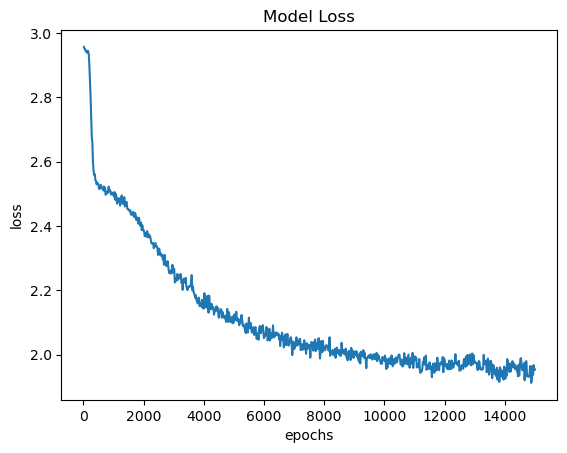

In [16]:
sns.lineplot(y=gpt_losses[1][1:],x=gpt_losses[0][1:])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epochs")

In [17]:
x="watson what are you"
x=torch.tensor([stoi[c] for c in x], device=device)[None, ...]
y=generate(gpt_model,x,100, top_k=3)
print("".join([itos[i] for i in y[0].tolist()]))

watson what are you and to seeme any time as alled,
and it the sider of the while, the shooks a sever a stain the said,


In [18]:
x="i am writing this prompt"
x=torch.tensor([stoi[c] for c in x], device=device)[None, ...]
y=generate(gpt_model,x,100, top_k=3)
print("".join([itos[i] for i in y[0].tolist()]))

i am writing this prompt to me at to
surped in the of as i see of the otat a sees, that to the matter and the was weredsed i
